In [1]:
%cd ../RADOM

# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from inference import Trajectory
from plotting import *
from models.two_species import get_Y

/home/mffang/workspace/Poisson-regression/RADOM


In [213]:
import time
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import scanpy as sc
import os

# Preprocessing

**check whitelist**

In [117]:
whitelist = np.loadtxt("/home/mffang/counts/Amadei/SRR17020581/indrops_version3_whitelist.txt",dtype=str)

In [118]:
their_data = sc.read("/home/mffang/counts/Amadei/GSE189425_RAW/GSM5701544_NE85_2.inex.txt")
their_data = their_data.T
their_data

AnnData object with n_obs × n_vars = 9122 × 24509

In [119]:
their_barcodes = []
for name in list(their_data.obs_names):
    barcode = name.split('_')[3]
    their_barcodes.append(barcode[:8]+barcode[-8:])

In [120]:
inwhitelist = [their_barcodes[i] in whitelist for i in range(len(their_barcodes))]
print(np.sum(inwhitelist))

8856


Therefore, the default whitelist does not contain all barcodes

**generate whitelist**

In [132]:
dir_name = "/home/mffang/counts/Amadei/GSE189425_RAW/"
files = os.listdir(dir_name)
whitelist = []
for file in files:
    if file[:3]=="GSM":
        print(file)
        df = pd.read_csv(dir_name+file, delimiter = "\t")
        for name in list(df.columns):
            barcode = name.split('_')[-1]
            barcode = barcode[:8]+barcode[-8:]
            if barcode not in whitelist:
                whitelist.append(barcode)
        print(len(whitelist))

GSM5701532_ETiX_d8_2.inex.txt
10294
GSM5701546_NE85_4.inex.txt
20985
GSM5701535_ETiX_d8_5.inex.txt
31793
GSM5701523_ETiX_d5_2.inex.txt
35427
GSM5701522_ETiX_d5_1.inex.txt
39092
GSM5701545_NE85_3.inex.txt
46435
GSM5701529_ETiX_d6_5.inex.txt
52973
GSM5701537_ETiX_d8_EXE_1.inex.txt
60247
GSM5701534_ETiX_d8_4.inex.txt
68212
GSM5701547_NE85_5.inex.txt
72519
GSM5701548_NE85_6.inex.txt
76507
GSM5701542_NE75_2.inex.txt
80188
GSM5701549_NE85_EXE.inex.txt
85956
GSM5701526_ETiX_d6_2.inex.txt
87092
GSM5701528_ETiX_d6_4.inex.txt
88637
GSM5701541_NE75_1.inex.txt
90875
GSM5701531_ETiX_d8_1.inex.txt
93477
GSM5701533_ETiX_d8_3.inex.txt
96507
GSM5701539_NE65_1.inex.txt
97549
GSM5701524_ETiX_d5_3.inex.txt
98700
GSM5701538_ETiX_d8_EXE_2.inex.txt
101867
GSM5701536_ETiX_d8_6.inex.txt
105479
GSM5701540_NE65_2.inex.txt
106163
GSM5701525_ETiX_d6_1.inex.txt
106917
GSM5701543_NE85_1.inex.txt
108579
GSM5701544_NE85_2.inex.txt
109723
GSM5701530_ETiX_d6_6.inex.txt
110759
GSM5701527_ETiX_d6_3.inex.txt
111291


In [143]:
whitelist = np.sort(whitelist)

In [146]:
np.savetxt("/home/mffang/counts/Amadei/whitelist.txt",whitelist,fmt="%s",delimiter='\n')

# Analysis

In [172]:
adata = sc.read("/home/mffang/counts/Amadei/SRR17020582/counts_filtered/adata.h5ad")
adata

AnnData object with n_obs × n_vars = 27900 × 55471
    var: 'gene_name'
    layers: 'spliced', 'unspliced'

In [173]:
their_data = sc.read("/home/mffang/counts/Amadei/GSE189425_RAW/GSM5701543_NE85_1.inex.txt")
their_data = their_data.T
their_data

AnnData object with n_obs × n_vars = 11875 × 23449

In [198]:
their_data.obs

""
n_E85_1_AAACAAACTGGTAACGAACCCTTG
n_E85_1_AAACAAACTGGTAACGACATCTAT
n_E85_1_AAACAAACTGGTAACGAGCGCCTT
n_E85_1_AAACAAACTGGTAACGAGGTTGTG
n_E85_1_AAACAAACTGGTAACGAGTTTAGA
...
n_E85_1_TGTTATCATGGTAACGTGCCATCG
n_E85_1_TGTTATCATGGTAACGTGGTATGA
n_E85_1_TGTTATCATGGTAACGTGTGGCTA
n_E85_1_TGTTATCATGGTAACGTTCGGCCT


In [215]:
def hamming_distance(s1, s2):
    if len(s1) != len(s2):
        raise ValueError("Strand lengths are not equal!")
    return sum(ch1 != ch2 for ch1,ch2 in zip(s1,s2))

In [219]:
their_barcodes = []
for name in list(their_data.obs_names):
    barcode = name.split('_')[3]
    assert hamming_distance(barcode[8:16],"TGGTAACG")<=1, barcode[8:16]
    their_barcodes.append(barcode[:8]+barcode[-8:])

In [175]:
their_gene_ID = []
gene_names = []
for name in list(their_data.var_names):
    ID, gene_name = name.split('_')
    their_gene_ID.append(ID)
    gene_names.append(gene_name)
ID2names = dict(zip(their_gene_ID,gene_names))
len(their_gene_ID)

23449

In [177]:
data = adata[adata.obs_names.isin(their_barcodes),:]
data

View of AnnData object with n_obs × n_vars = 11823 × 55471
    var: 'gene_name'
    layers: 'spliced', 'unspliced'

In [178]:
gene_indices = []
for i,t in enumerate(data.var_names):
    gene = t.split('.')[0]
    if gene in ID2names:
        gene_indices.append(i)

In [179]:
data = data[:,gene_indices]
data

View of AnnData object with n_obs × n_vars = 11823 × 23449
    var: 'gene_name'
    layers: 'spliced', 'unspliced'

In [194]:
adata.layers["spliced"].sum(axis=1).max()

1083.0

In [193]:
adata.layers["unspliced"].sum(axis=1).mean()

42.46276

In [189]:
data.layers["unspliced"].sum(axis=1).mean()

71.80149

In [190]:
data.layers["spliced"].sum(axis=1).mean()

339.3885

In [197]:
their_data.X.sum(axis=1).max()

16541.0

In [89]:
np.sort(data.var_names)

array(['ENSMUSG00000000001.4', 'ENSMUSG00000000003.15',
       'ENSMUSG00000000028.15', ..., 'ENSMUSG00000118638.1',
       'ENSMUSG00000118639.1', 'ENSMUSG00000118640.1'], dtype=object)

In [72]:
adata.obs

""
barcode


In [15]:
adata

AnnData object with n_obs × n_vars = 547805 × 23932
    obs: 'cell', 'exp', 'nCount_RNA', 'nFeature_RNA', 'time', 'percent.ribo', 'percent.mt'
    var: 'gene'

/Users/fang/opt/anaconda3/lib/python3.7/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/fang/opt/anaconda3/lib/python3.7/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/fang/opt/anaconda3/lib/python3.7/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/fang/opt/anaconda3/lib/python3.7/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


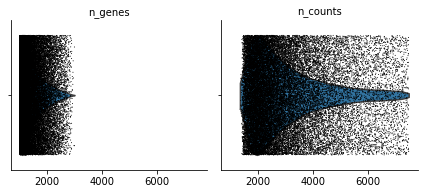

In [38]:
sc.pl.violin(adata, ['n_genes', 'n_counts'], jitter=0.4, multi_panel=True)

# Trajectory

In [4]:
hrs_00_02 = sc.read_loom('../data/drosophila_hrs_00_02.loom')
hrs_00_02

/Users/fang/opt/anaconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 13809 × 15437
    obs: 'cell', 'exp', 'nCount_RNA', 'nFeature_RNA', 'n_counts', 'n_genes', 'obs_names', 'percent.mt', 'percent.ribo', 'time'
    var: 'gene', 'n_cells', 'var_names'

In [5]:
sc.pp.highly_variable_genes(hrs_00_02,n_top_genes=20,flavor='seurat_v3')

In [6]:
adata = hrs_00_02[hrs_00_02.obs['exp']=='exp10']

In [7]:
idx = adata.var['highly_variable']
gene_list=adata.var['gene'][idx]
X=adata.X.toarray()
X=X[:,idx,None]
X.shape

(1165, 20, 1)

In [8]:
tau=(0,1)
topo = np.array([[0],[1],[2]])
traj = Trajectory(topo, tau, model="one_species")
Q, elbos = traj.fit(X, n_init=1, parallel=True, n_threads=4, seed=63)

run method fit_multi_init
trial 1


100%|███████████████████████████████████████████| 20/20 [00:14<00:00,  1.35it/s]


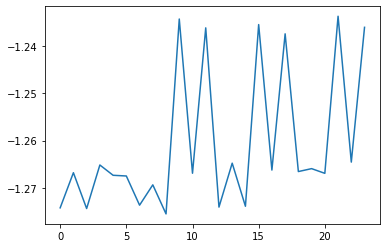

In [9]:
plt.plot(elbos)

In [12]:
plot_idx = gene_list.isin(['bcd','eve','med','hunchback'])
gene_list[plot_idx]

Series([], Name: gene, dtype: object)

In [ ]:
plt.plot(elbos)